In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

from Inference.GeNNeVI import GeNNeVI
from Inference.FuNNeVI import FuNNeVI
from Models import BigGenerator
from Metrics import RMSE, LPP, PICP, MPIW

from tempfile import TemporaryDirectory



In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
from Experiments.foong import Setup
setup=Setup(device)
   
loglikelihood=setup.loglikelihood

size_data=setup.n_train_samples
param_count=setup.param_count
input_dim=setup.input_dim

def prior(n):
    return setup.sigma_prior*torch.randn(size=(n,param_count), device= device)

batch=20

# GeNNeVI

In [4]:
lat_dim=5

NNE=1
p_norm=2
n_samples_KL=500
n_samples_LL=100
max_iter=30000
learning_rate=0.005
patience=1000
min_lr= 0.001
lr_decay=.7


In [5]:
GeN = BigGenerator(lat_dim, param_count,device).to(device)

optimizer = GeNNeVI(loglikelihood, batch, size_data, prior,
                      NNE, n_samples_KL, n_samples_LL, 
                      max_iter, learning_rate, min_lr, patience, lr_decay,
                      device)

ELBO = optimizer.run(GeN)
ELBO.item()

 82%|████████▏ | 24485/30000 [02:21<00:31, 172.49it/s, ELBO=-8.33, KL=50.9, LL=16.8, lr=0.00084]  


-45.76502990722656

In [6]:
theta=GeN(1000)
log_device=device
LPP_test, RMSE_test, _, PICP_test, MPIW_test = setup.evaluate_metrics(theta,log_device)

print('RMSE: '+str(np.round(RMSE_test[0].item(),decimals=2))+' ± '+str(np.round(RMSE_test[1].item(),decimals=2)))
print('LPP: '+str(np.round(LPP_test[0].item(),decimals=2))+' ± '+str(np.round(LPP_test[1].item(),decimals=2)))
print('PICP: '+str(np.round(PICP_test.item(),decimals=2)))
print('MPIW: '+str(np.round(MPIW_test.item(),decimals=2)))


RMSE: 1.24 ± 1.4
LPP: -40.1 ± 67.15
PICP: 0.04
MPIW: 0.46


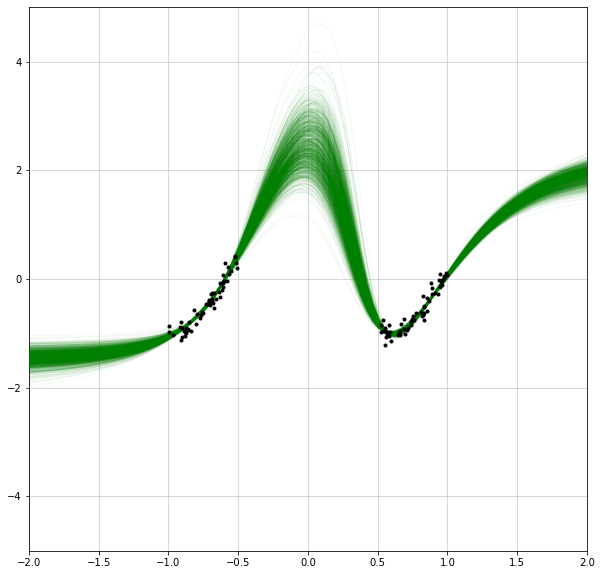

In [7]:
%matplotlib inline
if setup.plot:
    fig=setup.makePlot(theta,device)

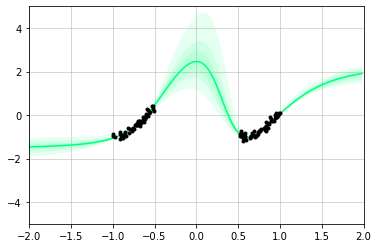

In [8]:
%matplotlib inline
if setup.plot:
    fig=setup.makePlotCI(theta,device)

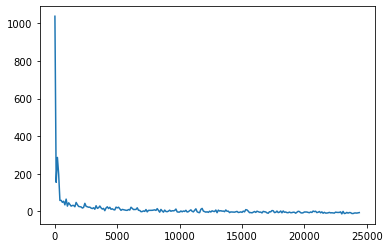

In [9]:
%matplotlib inline
time_line=100*torch.arange(0,len(optimizer.scores['ELBO']))
#optimizer.scores
plt.plot(time_line,optimizer.scores['ELBO']) #'KL','LL', 'lr'

# FuNNeVI

In [12]:
ratio_ood=1.
n_samples_FU=30

projection=lambda x,y: setup.projection(x,y, n_samples_FU, ratio_ood)
#projection=lambda x,y: setup.projection_normal(x,y, n_samples_FU, sigma_input)

lat_dim=5

NNE=1
p_norm=2
n_samples_KL=500
n_samples_LL=100
max_iter=30000
learning_rate=0.005
patience=1000
min_lr= 0.001
lr_decay=.7



In [13]:
GeN = BigGenerator(lat_dim, param_count,device).to(device)

optimizer = FuNNeVI(loglikelihood, batch, size_data, prior, projection, p_norm, NNE,
                    n_samples_KL, n_samples_LL, max_iter, learning_rate, min_lr, patience, lr_decay, device)

ELBO = optimizer.run(GeN)
ELBO.item()

 42%|████▏     | 12460/30000 [01:27<02:02, 142.98it/s, ELBO=-13.3, KL=56.6, LogLike=22.8, lr=0.00084] 


-13.325124740600586

In [ ]:
theta=GeN(1000)
log_device=device
LPP_test, RMSE_test, _, PICP_test, MPIW_test = setup.evaluate_metrics(theta,log_device)

print('RMSE: '+str(np.round(RMSE_test[0].item(),decimals=2))+' ± '+str(np.round(RMSE_test[1].item(),decimals=2)))
print('LPP: '+str(np.round(LPP_test[0].item(),decimals=2))+' ± '+str(np.round(LPP_test[1].item(),decimals=2)))
print('PICP: '+str(np.round(PICP_test.item(),decimals=2)))
print('MPIW: '+str(np.round(MPIW_test.item(),decimals=2)))


In [ ]:
%matplotlib inline
if setup.plot:
    fig=setup.makePlot(theta,device)

In [ ]:
%matplotlib inline
if setup.plot:
    fig=setup.makePlotCI(theta,device)

In [ ]:
%matplotlib inline
time_line=100*torch.arange(0,len(optimizer.scores['ELBO']))
#optimizer.scores
plt.plot(time_line,optimizer.scores['ELBO']) #'KL','LL', 'lr'